In [1]:
#
# Scattering of a plane wave by a sound-hard circle using high-order mesh
# =======================================================================
#
# This demo illustrates how to:
#
# * Compute the scattering of a plane wave by a sound-hard circle
# * Use quadratic mesh elements to represent the circular boundary accurately
# * Employ an "adiabatic layer" to truncate the domain
# * Evaluate the FEM solution at specified grid points
# * Compare the approximation to the analytical solution
# * Make a nice plot of the solution in the domain
#
# Adiabatic absorbers are presented in detail in
# "The failure of perfectly matched layers, and towards their redemption
#  by adiabatic absorbers" - Oskooi et al. (2008)

import time
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import dolfinx

# from dolfinx import Function, FunctionSpace, cpp, geometry
# from dolfinx.cpp.io import extract_local_entities, perm_gmsh
# from dolfinx.io import (XDMFFile, extract_gmsh_geometry,
                        # extract_gmsh_topology_and_markers, ufl_mesh_from_gmsh)
from dolfinx.mesh import CellType,create_mesh, meshtags_from_entities, locate_entities_boundary
# from ufl import (dx, grad, inner, dot, FiniteElement, TestFunction,
#                  TrialFunction, FacetNormal, Measure, lhs, rhs)
from dolfinx.graph import adjacencylist
from dolfinx import fem, mesh, io, geometry
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile, distribute_entity_data, gmshio
from ufl import (dx, grad, inner, TestFunction, TrialFunction,FacetNormal,Measure,
                  lhs, rhs, dot)
from mpi4py import MPI
from petsc4py import PETSc

# from analytical import sound_hard_circle

# This implementation relies on the complex mode of dolfin-x, invoked by
# executing the command:
# source /usr/local/bin/dolfinx-complex-mode
if not np.issubdtype(PETSc.ScalarType, np.complexfloating):
    print('This demo only works with PETSc-complex')
    exit()

dtype = np.float64


'''                        Problem parameters                               '''
k0 = 10                  # wavenumber
wave_len = 2*np.pi / k0  # wavelength
radius = 1 * wave_len    # scatterer radius
d_air = 4 * wave_len     # distance between scatterer and absorbing layer

'''    Discretization parameters: polynomial degree and mesh resolution     '''
degree = 3  # polynomial degree
n_wave = 5  # number of mesh elements per wavelength

'''                   Adiabatic absorber settings                           '''
# The adiabatic absorber is a PML-type layer in which absorption is used to
# attenutate outgoing waves. Adiabatic absorbers aren't as perfect as PMLs so
# must be slightly wider: typically 2-5 wavelengths gives adequately small
# reflections.
d_absorb = 2 * wave_len    # depth of absorber

# Increase the absorption within the layer gradually, as a monomial:
# sigma(x) = sigma_0 * x^d; choices d=2,3 are popular choices.
deg_absorb = 2    # degree of absorption monomial

# The constant sigma_0 is chosen to achieve a specified "round-trip" reflection
# of a wave that through the layer, reflects and returns back into the domain.
# See Oskooi et al. (2008) for more details.
RT = 1.0e-6       # round-trip reflection
sigma0 = -(deg_absorb + 1) * np.log(RT) / (2.0 * d_absorb)

'''                             Meshing                                     '''
# For this problem we use a square mesh with triangular elements.
# The domain width is 2 * (radius + d_air + d_absorb)
dim_x = 2 * (radius + d_air + d_absorb)

# The mesh element size is h_elem
h_elem = wave_len / n_wave

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)
model = gmsh.model()
gdim = 2  # dimension of the problem

# The mesh is a square with a disk cut out
rank = MPI.COMM_WORLD.rank
if rank == 0:
    rectangle = model.occ.addRectangle(-dim_x/2, -dim_x/2, 0,
                                            dim_x, dim_x, tag=1)
    obstacle = model.occ.addDisk(0, 0, 0, radius, radius)
    fluid = model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
    model.occ.synchronize()

    fluid_marker = 1
    volumes = model.getEntities(dim=gdim)
    model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
    model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

    obstacle_marker = 1
    surfaces = model.getEntities(dim=gdim-1)
    model.addPhysicalGroup(surfaces[0][0], [surfaces[0][1]],
                                obstacle_marker)
    model.setPhysicalName(surfaces[0][0], obstacle_marker, "Obstacle")

    model.mesh.setSize(model.getEntities(0), h_elem)
    model.occ.synchronize()
    model.mesh.generate(3)
    model.mesh.setOrder(2)  # Command required for quadratic elements

    # Create dolfinx mesh on process 0
    x = gmshio.extract_geometry(model)
    gmsh_cell_id = MPI.COMM_WORLD.bcast(
        model.mesh.getElementType("triangle", 2), root=0)
    topologies = gmshio.extract_topology_and_markers(model)
    cells = topologies[gmsh_cell_id]["topology"]
    cell_data = topologies[gmsh_cell_id]["cell_data"]
    num_nodes = MPI.COMM_WORLD.bcast(cells.shape[1], root=0)
    gmsh_facet_id = model.mesh.getElementType("line", 2)
    marked_facets = topologies[gmsh_facet_id]["topology"].astype(np.int64)
    facet_values = topologies[gmsh_facet_id]["cell_data"].astype(np.int32)
else:
    # Create dolfinx mesh on other processes
    gmsh_cell_id = MPI.COMM_WORLD.bcast(None, root=0)
    num_nodes = MPI.COMM_WORLD.bcast(None, root=0)
    cells, x = np.empty([0, num_nodes]), np.empty([0, 3])
    marked_facets = np.empty((0, 3), dtype=np.int64)
    facet_values = np.empty((0,), dtype=np.int32)

# Permute the topology from GMSH to DOLFINx ordering
domain = gmshio.ufl_mesh(gmsh_cell_id, 2, dtype=dtype)
gmsh_tri6 = gmshio.cell_perm_array(CellType.triangle, cells.shape[1])
cells = cells[:, gmsh_tri6]
mesh = create_mesh(MPI.COMM_WORLD, cells, x[:, :2], domain)

# Permute also entities which are tagged
gmsh_line3 = gmshio.cell_perm_array(CellType.interval, 3)
marked_facets = marked_facets[:, gmsh_line3]

local_entities, local_values = distribute_entity_data(
    mesh, 1, marked_facets, facet_values)

mesh.topology.create_connectivity(1, 0)
mt = meshtags_from_entities(mesh, 1, adjacencylist(local_entities), local_values)

n = FacetNormal(mesh)
ds = Measure("ds", subdomain_data=mt)




/home/vicente/miniconda3/envs/fenicsx-complex-latest/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:

'''        Incident field, wavenumber and adiabatic absorber functions      '''

def incident(x):
    # Plane wave travelling in positive x-direction
    return np.exp(1.0j * k0 * x[0])

def minus_incident(x):
    # Plane wave travelling in positive x-direction
    return -np.exp(1.0j * k0 * x[0])


def adiabatic_layer(x):
    '''          Contribution to wavenumber k in absorbing layers          '''
    # In absorbing layer, have k = k0 + 1j * sigma
    # => k^2 = (k0 + 1j*sigma)^2 = k0^2 + 2j*sigma - sigma^2
    # Therefore, the 2j*sigma - sigma^2 piece must be included in the layer.

    # Find borders of width d_absorb in x- and y-directions
    in_absorber_x = (np.abs(x[0]) >= dim_x/2 - d_absorb)
    in_absorber_y = (np.abs(x[1]) >= dim_x/2 - d_absorb)

    # Function sigma_0 * x^d, where x is depth into adiabatic layer
    sigma_x = sigma0 * ((np.abs(x[0])-(dim_x/2-d_absorb))/d_absorb)**deg_absorb
    sigma_y = sigma0 * ((np.abs(x[1])-(dim_x/2-d_absorb))/d_absorb)**deg_absorb

    # 2j*sigma - sigma^2 in absorbing layers
    x_layers = in_absorber_x * (2j * sigma_x * k0 - sigma_x**2)
    y_layers = in_absorber_y * (2j * sigma_y * k0 - sigma_y**2)

    return x_layers + y_layers


# Define function space
# FE = FiniteElement("Lagrange", mesh.ufl_cell(), degree)
# V = FunctionSpace(mesh, FE)
V = fem.functionspace(mesh, ("Lagrange", degree))

# Interpolate absorbing layer piece of wavenumber k_absorb onto V
k_absorb = fem.Function(V)
k_absorb.interpolate(adiabatic_layer)

# Interpolate incident wave field onto V
ui = fem.Function(V)
ui.interpolate(incident)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(u), grad(v)) * dx - k0**2 * inner(u, v) * dx - \
    k_absorb * inner(u, v) * dx

def foo(x):
     return 0*x[0]

f = fem.Function(V)
f.interpolate(foo)

L = inner(f, v) * dx

facets = locate_entities_boundary(
    mesh,
    dim=(mesh.topology.dim - 1),
    marker=lambda x: np.sqrt(x[0]**2+x[1]**2)<radius+1,
)

dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

u_bc = fem.Function(V)
u_bc.interpolate(minus_incident)
bc = fem.dirichletbc(u_bc, dofs=dofs)

'''           Assemble matrix and vector and set up direct solver           '''
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type": "mumps"},)

start = time.time()
uh = problem.solve()
end = time.time()
time_elapsed = end - start
print('Solve time: ', time_elapsed)

Nx = int(np.ceil(dim_x/wave_len * 10))
Ny = Nx

# Grid does not include absorbing layers
dim_in = dim_x - 2 * d_absorb

# Grid points
xmin, xmax, ymin, ymax = [-dim_in/2, dim_in/2, -dim_in/2, dim_in/2]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

points_2d = points[:2, :]

# Locate grid points inside the circle. These are outside the computation
# domain so we will ultimately set the field here to zero.
in_circ = points[0, :]**2 + points[1, :]**2 <= (radius)**2
in_circ_2d = points_2d[0, :]**2 + points_2d[1, :]**2 <= (radius)**2
points[0, in_circ] = -radius - wave_len / 10
points[1, in_circ] = radius + wave_len / 10
points[2, in_circ] = 0.

# Bounding box tree etc for function evaluations
tree = geometry.bb_tree(mesh, mesh.topology.dim)

cell_candidates = geometry.compute_collisions_points(tree, points.T)
colliding_cells = geometry.compute_colliding_cells(
            mesh, cell_candidates, points.T
        )

cells = []
points_on_proc = []

for i, point in enumerate(points.T):
            if len(colliding_cells.links(i)) > 0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])

# Evaluate scattered and incident fields at grid points
u_sca = uh.eval(points.T, cells)
inc_field = incident(points_2d)
u_inc = inc_field.reshape((Nx, Ny))

# # Evaluate scattered and incident fields at grid points
# u_sca_temp = u.eval(points.T, cells)
u_sca[in_circ_2d] = 0.0            # Set field inside circle to zero
u_sca = u_sca.reshape((Nx, Ny))    # Reshape
inc_field = incident(points_2d)
inc_field[in_circ_2d] = 0.0             # Set field inside circle to zero
u_inc = inc_field.reshape((Nx, Ny))

# Sum to give total field
u_total = u_inc + u_sca


Solve time:  1.2276184558868408


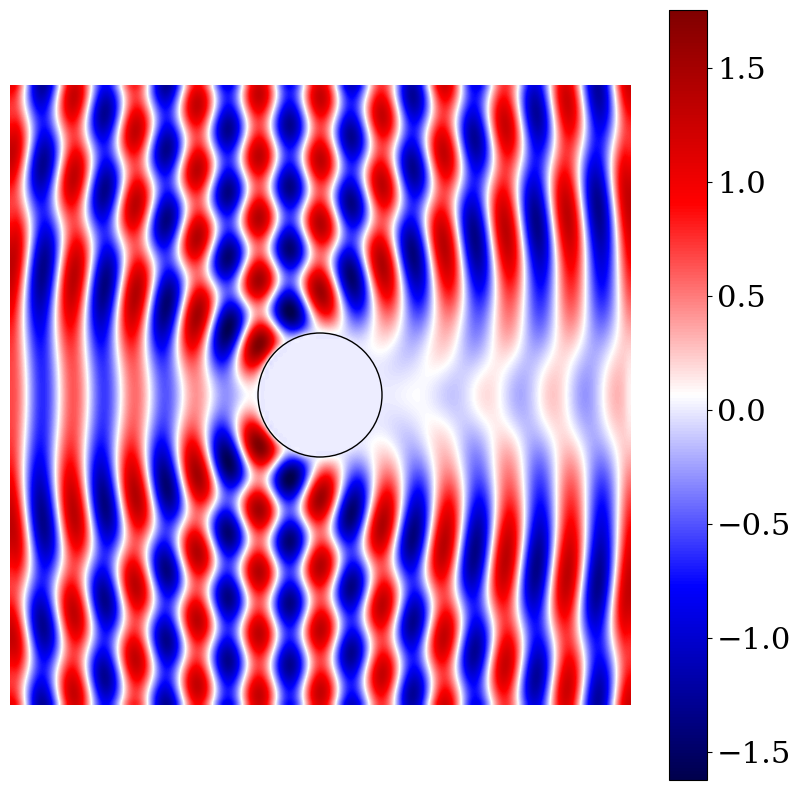

In [3]:
'''                     Plot field and save figure                          '''
plt.rc('font', family='serif', size=22)
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plt.imshow(np.fliplr(np.real(u_total)).T,
           extent=[-dim_in/2, dim_in/2, -dim_in/2, dim_in/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16')
circle = plt.Circle((0., 0.), radius, color='black', fill=False)
ax.add_artist(circle)
plt.axis('off')
plt.colorbar()
plt.show()

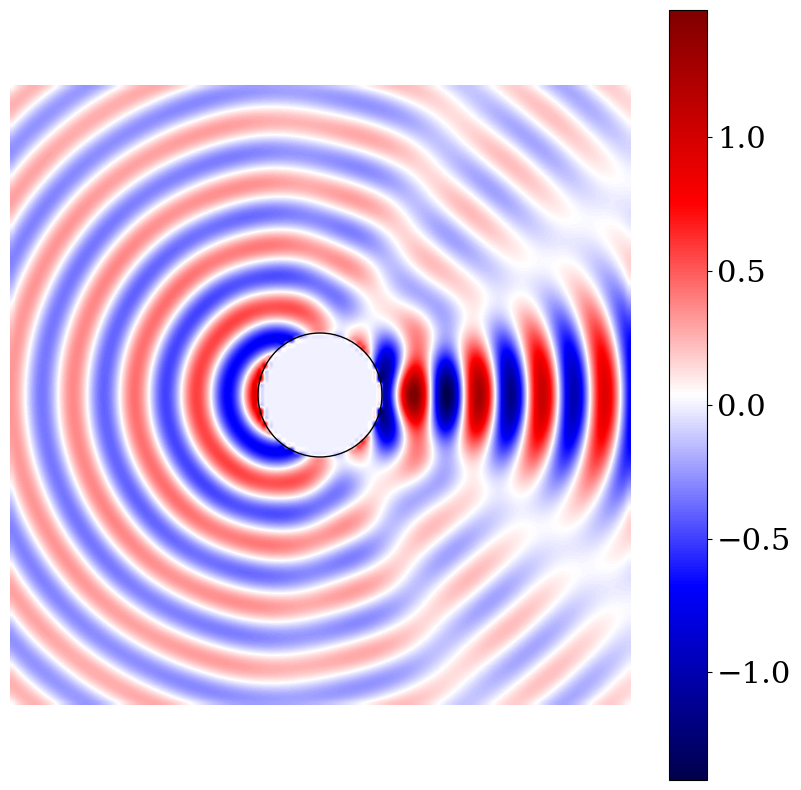

In [3]:
'''                     Plot field and save figure                          '''
plt.rc('font', family='serif', size=22)
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plt.imshow(np.fliplr(np.real(u_sca)).T,
           extent=[-dim_in/2, dim_in/2, -dim_in/2, dim_in/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16')
circle = plt.Circle((0., 0.), radius, color='black', fill=False)
ax.add_artist(circle)
plt.axis('off')
plt.colorbar()
plt.show()